# 0. Introduction to fitting spectral data
These tutorial notebooks will give a basic introduction to peak fitting of XRD scattering spectra using the the xrdfit package.

Some example spectra can be found in the example files folder and will be used here to demonstrate the various functions of the scripts.

The scripts use the lmfit package to do the actual fitting: https://lmfit.github.io/.

#### Import packages
Here we import the fitting functions from the `spectrum_fitting` module of the `xrdfit` package.

In [1]:
%matplotlib inline

from xrdfit.spectrum_fitting import PeakParams, FitSpectrum

# 1. Analysing a single diffraction pattern
## 1.1 Loading and plotting a spectrum

In this analysis we specify that an XRD experiment produces a **diffraction pattern**
$$I = f(\chi, 2\theta)$$
where $I$ is beam intensity, $\chi$ is the azimuthal angle and $2\theta$ is the scattering angle. The intensity is measured at a discreet number of azimuthal angles which results in the pattern being made up of a number of sectors which we call **cakes** (since the sectors look like a slice of cake).

<img src="images/cake_numbering.svg" alt="Illustration of cake numbering" title="Illustration of cake numbering" width="300" />
    
The **cakes** are ordered clockwise in the source data files but no information is provided about the location of the first cake. By convention the first cake in the data file is at the "East" position, 90&deg; clockwise from vertical. However, depending on how your data was captured, this may be different for your dataset and so when loading data you must provide the angle of the first cake as a parameter. This is given in degrees clockwise from vertical.

In [2]:
first_cake_angle = 90

A **spectrum** is a scan of intensity at a set azimuthal angle (cake) across a range of two theta angles.
A **spectrum** can have one or more **peaks** in intensity which are group of one or more **maxima**. A singlet peak has one maximum, a doublet peak has two maxima etc. In these tutorials these terms are used very specifically so the distinction is important to understanding how the fits work and what parameters to provide.

We start by analysing a single file which contains a single **diffraction pattern**.

First we define the path to the file to be analysed:

In [3]:
file_path = '../example_data/adc_041_7Nb_NDload_700C_15mms_00001.dat'

To fit the peaks in a spectrum, the diffraction pattern must first be loaded into a `FitSpectrum` object. The data for the whole diffraction pattern is stored in the instance of the object. In this case we name our instance *spectral_data*.

In [4]:
spectral_data = FitSpectrum(file_path, first_cake_angle)

Diffraction pattern successfully loaded from file.


A confirmation message is shown when the data is loaded.

We can then use the `plot_polar` method to plot the entire diffraction pattern:

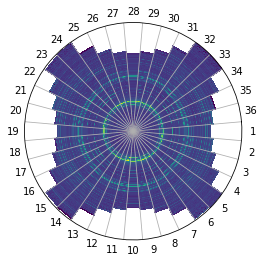

In [5]:
spectral_data.plot_polar()

The diffraction pattern is plotted with the cake number specified next to each segment. In the example data file we have used there are 36 cakes. The number of cakes is dependent on the input dataset (which is affected by how the user captured the data). The number of cakes in your dataset is determined automatically from the number of columns in the input dataset. The plot_polar command automatically adjusts to show the correct number of cakes and cake numbers according to the data file and first cake angle specified.


In order to plot a spectrum of intensity against $2\theta$ at a particular azimuthal angle, use the `plot` method, specifying which cake to plot.

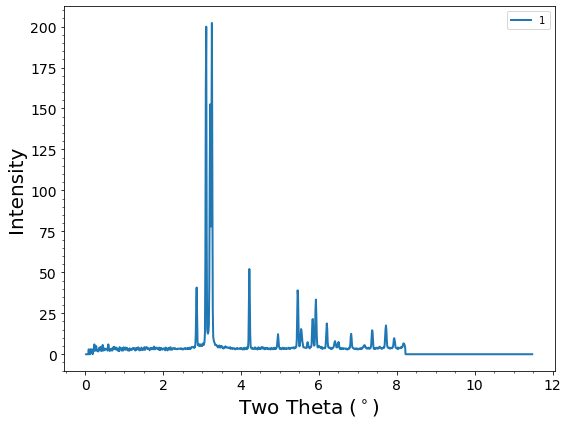

In [6]:
spectral_data.plot(1)

If you are using the an interactive matplotlib backend then it should be possible to zoom and pan the graph directly.
If you are using a non-interactive backend then you can specify the x-axis limits by passing these as a Tuple to the `plot` 
method. To show the raw data points, use the *show_points* parameter.

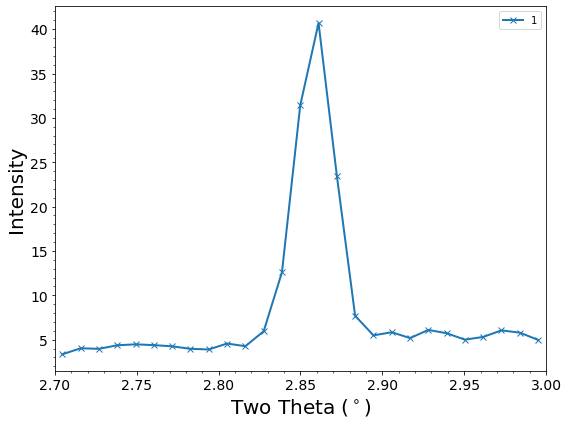

In [7]:
spectral_data.plot(1, (2.7, 3), show_points=True)

## 1.2 Fitting a single peak from a single cake

First we consider fitting single cakes. We will cover combining data from multiple cakes later.

To begin a fit, we need to define the **peak name** and **peak bounds**. The **peak name** is a unique peak identifier used to refer to the peak and the **peak bounds** specify where the peak is in the spectrum. All of the data between the upper and lower peak bound is used in the fit. We provide this data by initialising a `PeakParams` object. Generally speaking, is a good idea to at least a few data points either side of the peak so the fit can find the baseline. 

Lets begin by fitting the above peak in the range 2.75 to 2.95.

In [8]:
peak_params = PeakParams('(10-10)', (2.75, 2.95))

Because the peak is only a singlet peak we do not need to provide any fitting parameters. The fitting is able to automatically fit the maximum in a singlet peak without help.

Now we have specified where the peak is, the method `fit_peaks` does the fitting. We use the peak params we specified above and the number of the cake we want to fit (in this case cake 1) as parameters.

In [9]:
spectral_data.fit_peaks(peak_params, 1)

Fitting complete.


The results of the fit are stored in a `PeakFit` object which is stored in `FitSpectrum` object (this instance of FitSpectrum is called *spectral_data*). The Fit parameters can be viewed by using the values parameter of the `PeakFit` object.

In [10]:
spectral_data.fitted_peaks[0].result.values

{'maximum_1_center': 2.858862226947515,
 'maximum_1_sigma': 0.01337762769066966,
 'maximum_1_fraction': 0.024507619643795442,
 'maximum_1_amplitude': 1.0511617817446146,
 'background': 4.801194096851967}

To get a peak by name we can use the `get_fit` method of the `FitSpectrum` object.

In [11]:
spectral_data.get_fit("(10-10)").result.values

{'maximum_1_center': 2.858862226947515,
 'maximum_1_sigma': 0.01337762769066966,
 'maximum_1_fraction': 0.024507619643795442,
 'maximum_1_amplitude': 1.0511617817446146,
 'background': 4.801194096851967}

*values* is just a Python dictionary so individual values can be subscripted as normal, for example the peak centre is:

In [12]:
spectral_data.get_fit("(10-10)").result.values['maximum_1_center']

2.858862226947515

Full details on the fit can be seen by querying the `result` object directly. This is an lmfit ModelResult object - further documentation can be found at https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class

In [13]:
spectral_data.get_fit("(10-10)").result

There is also a method for plotting the fit:

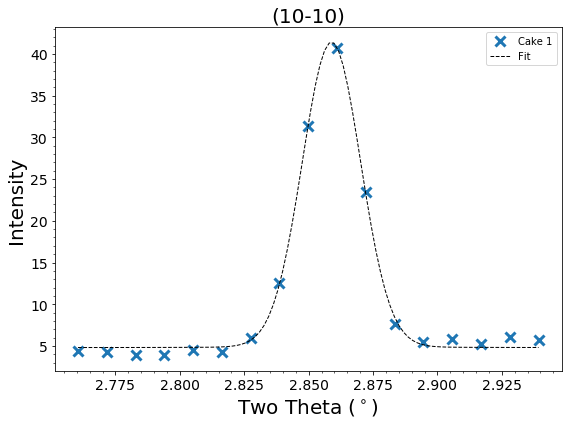

In [14]:
spectral_data.get_fit("(10-10)").plot()

For peaks with a single maxima we don't need to specify any fitting parameters - the algorithm can fit the peaks 
on its own using default values.

## <font color='red'>Notes on Chosing Peak Bounds for single peaks</font>
The peak bounds you choose to select a peak are used to tell the fitting code the data range to fit over. The peak bounds are also used to set the inital values of the parameters for the fit. For optimal fitting speed, try to set the peak bounds such that the range of the peak bounds is approximately 8 times the full width at half maximum (FWHM) of the peak bounds. Don't worry about this too much though since the fit result should not be sensitive to small changes in peak bounds and the fit will work if the peak bounds are set between 3 to 20 times the FWHM.

In this case the FWHM for this peak is 0.025 which means that peak bounds with range between 0.075 and 0.5 should work. 

Fitting complete.


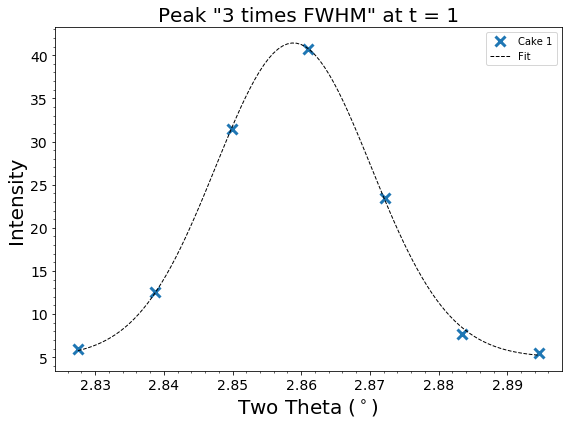

Fitting complete.


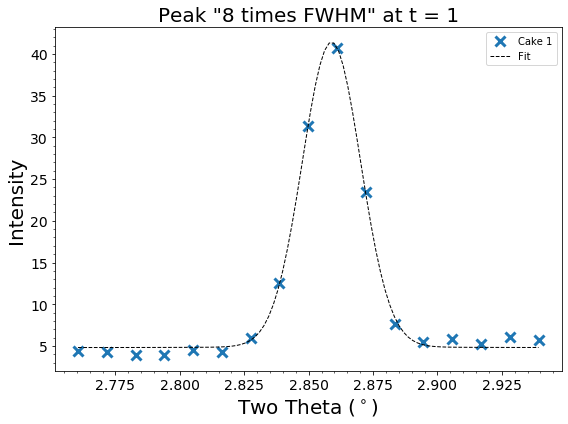

Fitting complete.


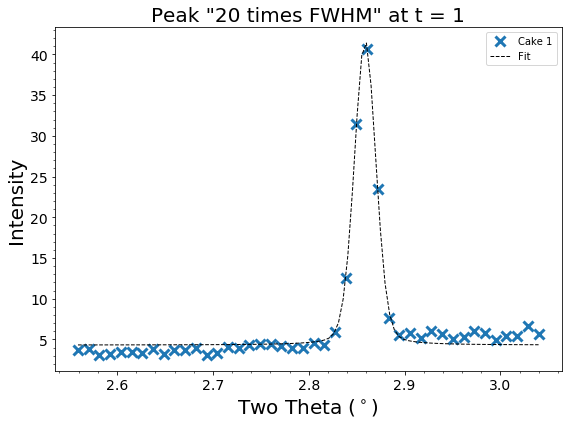

In [15]:
spectral_data.fit_peaks(PeakParams('3 times FWHM', (2.82, 2.90)), 1)
spectral_data.get_fit("3 times FWHM").plot(1)
spectral_data.fit_peaks(PeakParams('8 times FWHM', (2.75, 2.95)), 1)
spectral_data.get_fit("8 times FWHM").plot(1)
spectral_data.fit_peaks(PeakParams('20 times FWHM', (2.55, 3.05)), 1)
spectral_data.get_fit("20 times FWHM").plot(1)

## 1.3 Fitting multiple peaks simultaneously

It can be more convenient to specify multiple peaks and fit them all at once. Here we try to fit the first 4 peaks in the spectrum at once. First we get a good zoomed in view to see where the peaks are:

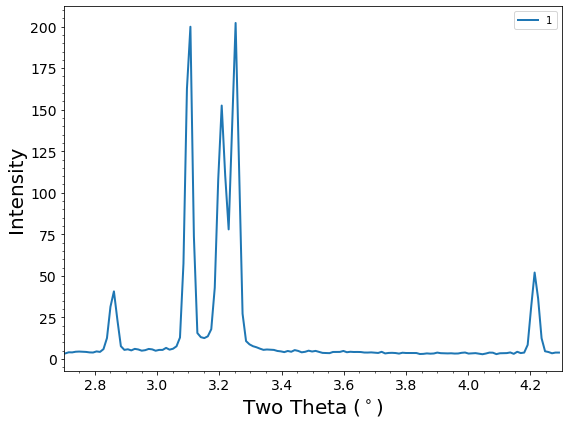

In [16]:
spectral_data.plot(1, (2.7, 4.3))

By providing a list of `PeakParams`, we can fit multiple peaks simultaneously. Once we have more than one set of peak params it can be a little confusing which is which. To make sure that we have set the peak params correctly we can use the `plot_peak_params` method of the `FitSpectrum` object to summarise the PeakParams we have set. As with any plotting function we can use the *show_points* parameter to see the raw data points.

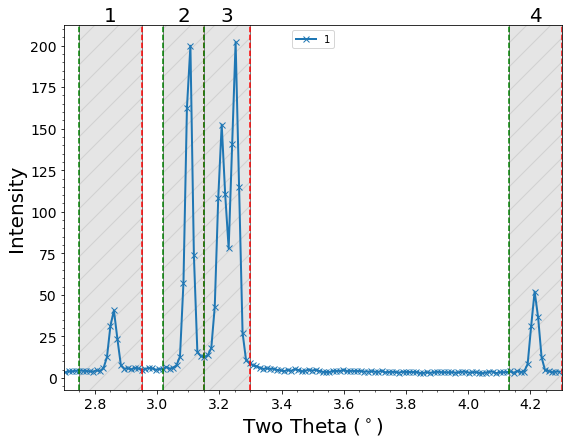

In [17]:
peak_params = [PeakParams('1', (2.75, 2.95)),
               PeakParams('2', (3.02, 3.15)),
               PeakParams('3',  (3.15, 3.30)),
               PeakParams('4', (4.13, 4.30))]
spectral_data.plot_peak_params(peak_params, 1, x_range=(2.7, 4.3), show_points=True)

The grey hashed region indicates the range of the PeakParam. The green dashed line indicates the start of a PeakParam region and the red dashed line indicates the end of the region. The code is looking for a peak in this area. The name of the peak as specified in the PeakParams is above each shaded area.

Now we have got the right PeakParams set up, pass the peak params to the `fit_peaks` method as before to do the fitting. Notice how we can use the `fitted_peaks` object to iterate over all of the fits in a `FitSpectrum` object.

Fitting complete.


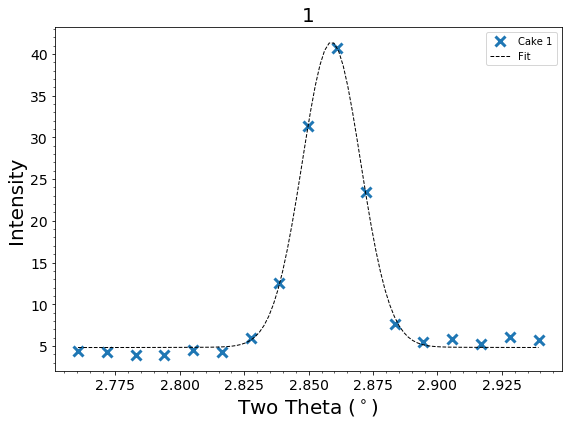

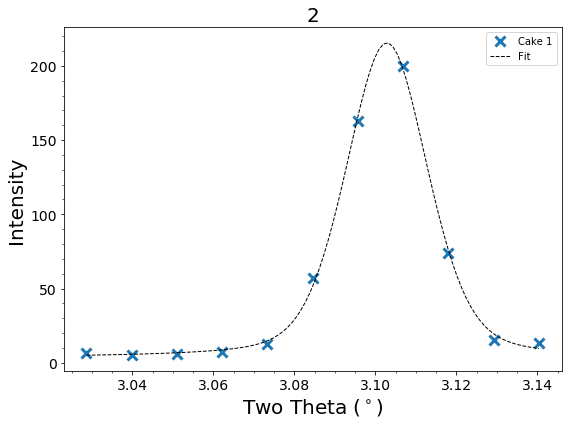

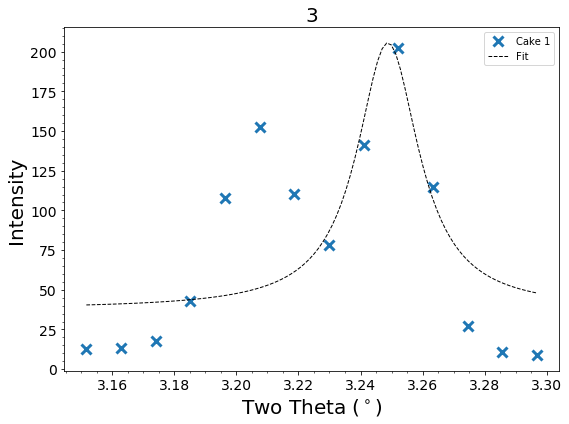

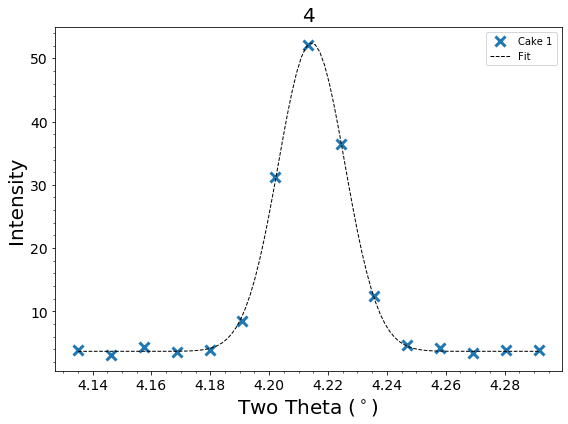

In [18]:
spectral_data.fit_peaks(peak_params, 1)

for fit in spectral_data.fitted_peaks:
    fit.plot()

You may notice that the third peak is fitted poorly since it is really two peaks close together. It would not be possible to fit the two peaks separately since they are too close together. We call cases like these **multiplet** peaks, a single peak with multiple **maxima**. In order to fit multiplet peaks we must provide the fitting with a little more information.

## 1.4 Fitting peaks with multiple maxima

First lets zoom in to get a better view of the doublet peak

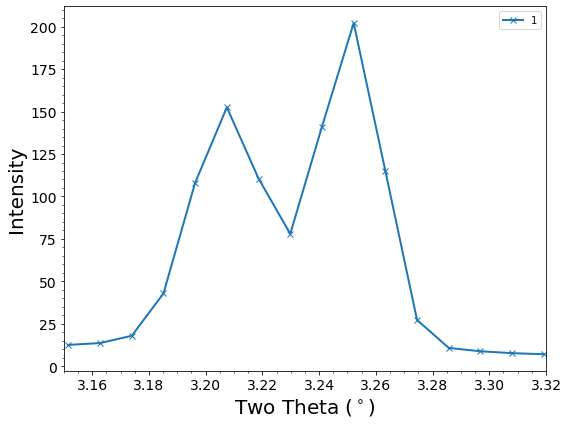

In [19]:
spectral_data.plot(1, (3.15, 3.32), show_points=True)

In order to tell the fitting algorithm to fit two **maxima** in a single peak we need to specify where one peak starts and the other ends. This means providing the `PeakParams` object with information about the position of the maximum for each peak - the **maxima bounds**.

We need to provide a min and max **maxima bound** for each peak. The min and max values bound a small region where the peak maximum can be found. While we want the **peak bounds** to be reasonably wide in order to include some baseline points, the **maxima bounds** can be specified quite tightly since they are just used to distinguish the two peak centers.

The **maxima bounds** must be provided as a list of Tuples, one for each maxima in the peak. Each tuple consists of a max and min value. The maxima_locations should be provided from left to right.

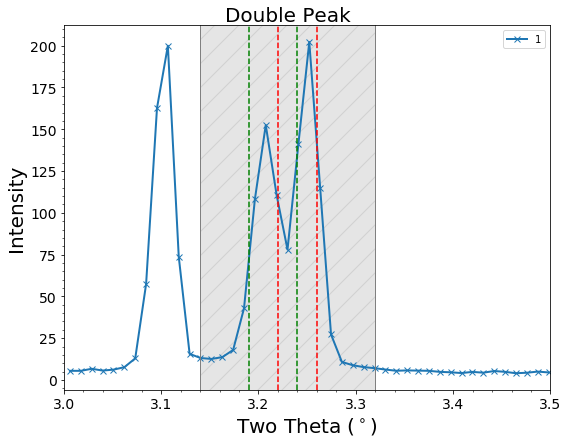

In [20]:
maxima_bounds = [(3.19, 3.22), (3.24, 3.26)]

peak_params = PeakParams('Double Peak', (3.14, 3.32), maxima_bounds)

spectral_data.plot_peak_params(peak_params, 1, (3.0, 3.5), show_points=True)

Here we have plotted the *peak_params* provided for the double peak. As before, the grey shaded area shows the **peak bounds** but this time we can see that the green and red dashed lines show the **maxima bounds**.

In the single peak example above the green and red lines were coincident with the edges of the shaded region. This is because the **maxima bounds** are set to the **peak bounds** if they are not specified.

We can now do the fit as before using the `fit_peaks` method.

Fitting complete.


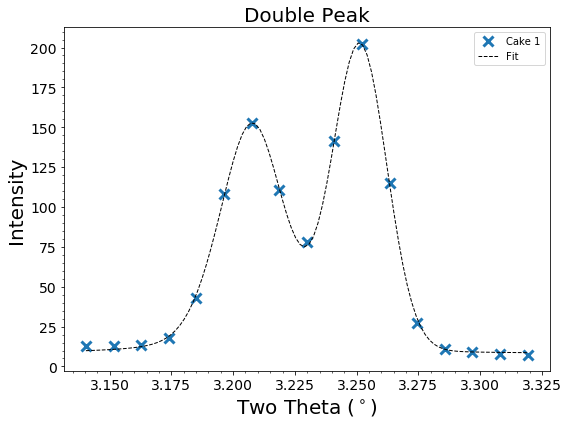

In [21]:
spectral_data.fit_peaks(peak_params, 1)
spectral_data.get_fit('Double Peak').plot()

Once you have set the `PeakParams`, it may be useful to print them out if you want to check exactly what peak params have been set or to output them as part of some sort of report. Printing the `PeakParams` object gives the string representation used to create it.

In [22]:
print(peak_params)

PeakParams('Double Peak', (3.14, 3.32), [(3.19, 3.22), (3.24, 3.26)])


## <font color='red'>Notes on Chosing Maxima Bounds for multiplet peaks</font>

While we can be fairly imprecise when specifying the peak bounds, the maxima bounds must be specified a little more carefully. You should make sure that the highest datapoint in the maximum is captured between the maxima bounds and ideally the maxima bounds should be specifed at the FWHM of the peak.

The maxima bounds are used to determine the starting parameters for the fitting function and so setting them well can significantly affect the quality of the fit and the fitting speed.

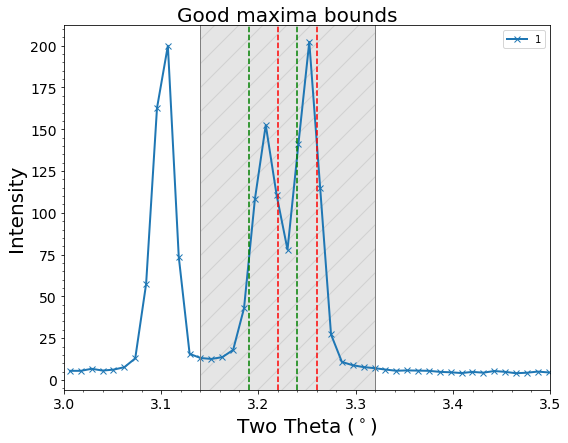

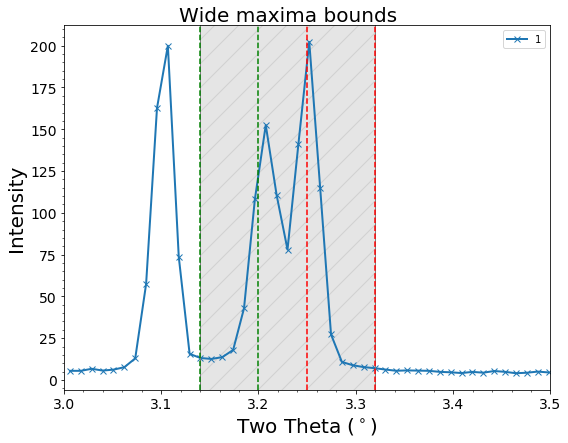

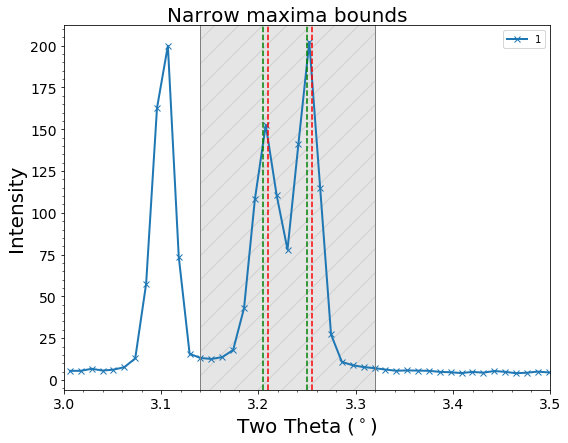

Fitting complete.


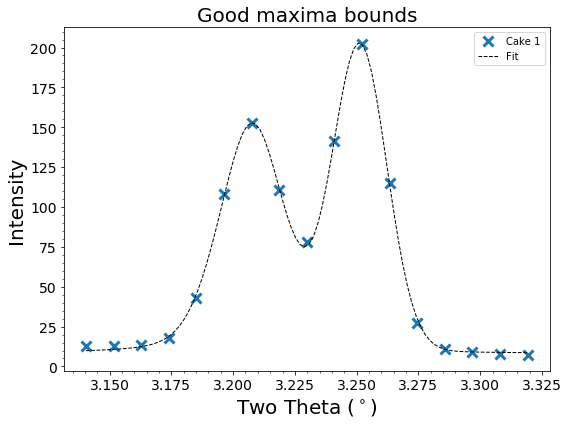

Fitting complete.


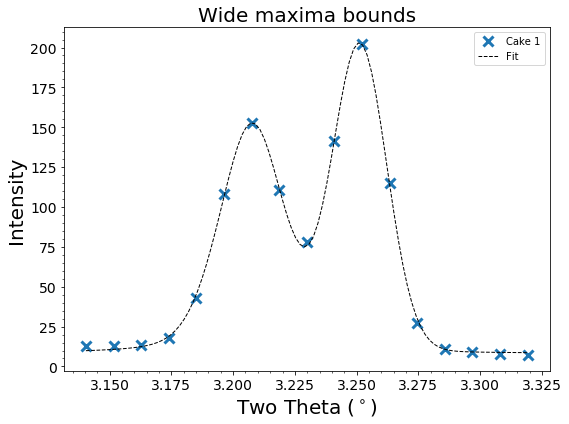

Fitting complete.


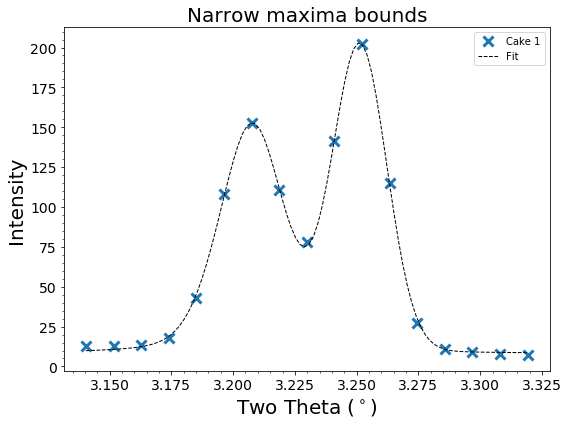

Good bounds fit took 0.047556 Seconds
Wide bounds fit took 0.057729 Seconds
Narrow bounds fit took 0.121077 Seconds


In [23]:
peak_params_1 = PeakParams('Good maxima bounds', (3.14, 3.32), [(3.19, 3.22), (3.24, 3.26)])
peak_params_2 = PeakParams('Wide maxima bounds', (3.14, 3.32), [(3.14, 3.25), (3.2, 3.32)])
peak_params_3 = PeakParams('Narrow maxima bounds', (3.14, 3.32), [(3.205, 3.21), (3.25, 3.255)])

spectral_data.plot_peak_params(peak_params_1, 1, (3.0, 3.5), show_points=True)
spectral_data.plot_peak_params(peak_params_2, 1, (3.0, 3.5), show_points=True)
spectral_data.plot_peak_params(peak_params_3, 1, (3.0, 3.5), show_points=True)

import time

# Time the good bounds fit
start_1 = time.perf_counter()
spectral_data.fit_peaks(peak_params_1, 1)
stop_1 = time.perf_counter()
spectral_data.get_fit("Good maxima bounds").plot()

# Time the wide bounds fit
start_2 = time.perf_counter()
spectral_data.fit_peaks(peak_params_2, 1)
stop_2 = time.perf_counter()
spectral_data.get_fit("Wide maxima bounds").plot()

# Time the narrow bounds fit
start_3 = time.perf_counter()
spectral_data.fit_peaks(peak_params_3, 1)
stop_3 = time.perf_counter()
spectral_data.get_fit("Narrow maxima bounds").plot()


print(f"Good bounds fit took {stop_1 - start_1:05f} Seconds")
print(f"Wide bounds fit took {stop_2 - start_2:05f} Seconds")
print(f"Narrow bounds fit took {stop_3 - start_3:05f} Seconds")

In this case the fit has converged well for all three sets of maxima bounds although the good bounds converge twice as fast.

While double the speed might not seem that significant, the difference can be much greater when fitting higher number of maxima (triplets, quartets etc.) or if the maxima are less distinct. If you are fitting many peaks over hundreds or thousands of datasets this can make a big difference.

Ultimately if the maxima bounds are too far out then the fitting may not converge and the fits will not be useful.

## 1.5. Putting it all together

To fit the single and doublet peaks at the same time we can combine `PeakParams` seamlessly as before. Going back to the above example, we can fit the first 4 peaks in the spectrum like this:

Fitting complete.


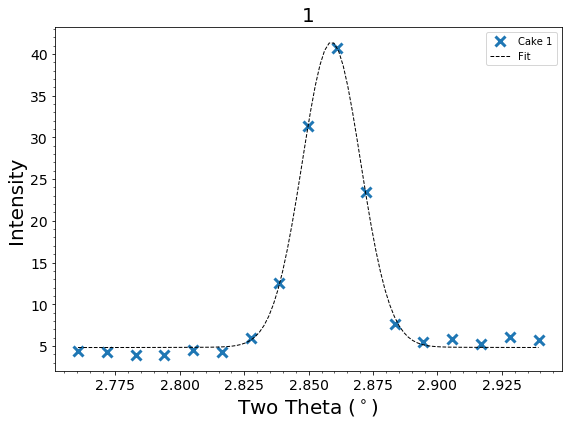

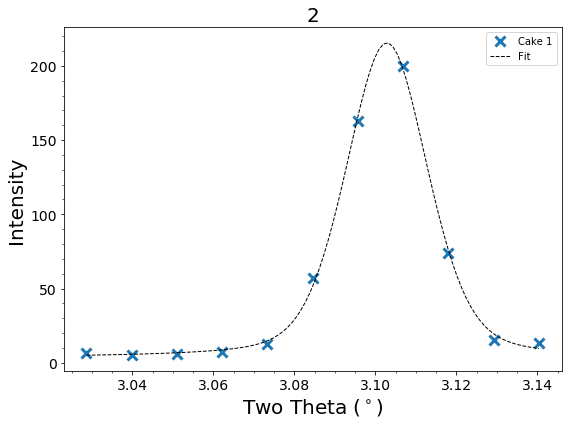

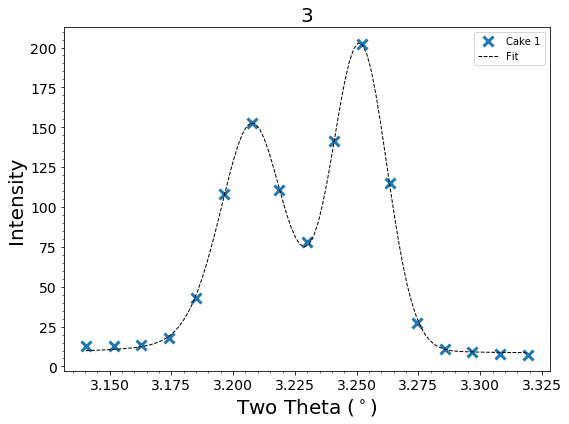

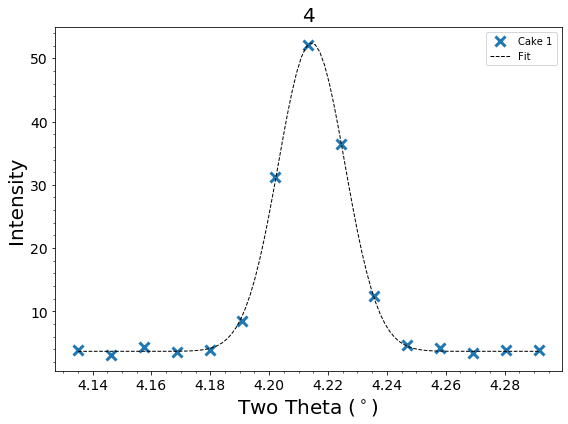

In [24]:
peak_params = [PeakParams('1', (2.75, 2.95)),
               PeakParams('2', (3.02, 3.15)),
               PeakParams('3',  (3.14, 3.32), [(3.19, 3.22), (3.24, 3.26)]),
               PeakParams('4', (4.13, 4.30))]

spectral_data.fit_peaks(peak_params, 1)

for fit in spectral_data.fitted_peaks:
    fit.plot()

This now fits all of the peaks appropriately.

However, peaks 2 and 3 are quite close - they don't have the many baseline points between them. In this case they have fitted OK, but if the fit was having trouble it would also be valid to combine the peaks as a triplet peak.

Fitting complete.


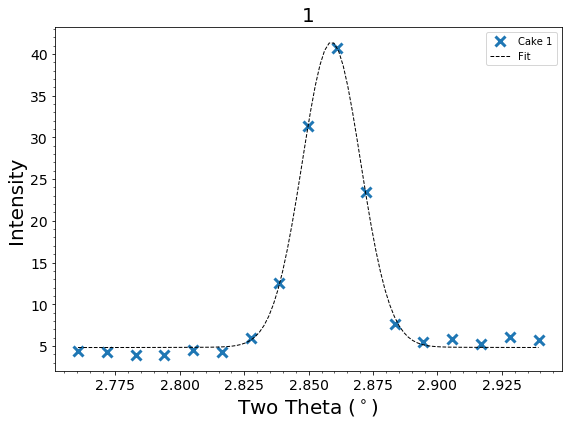

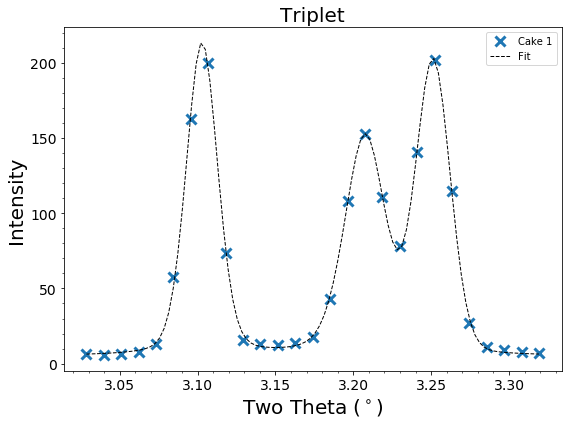

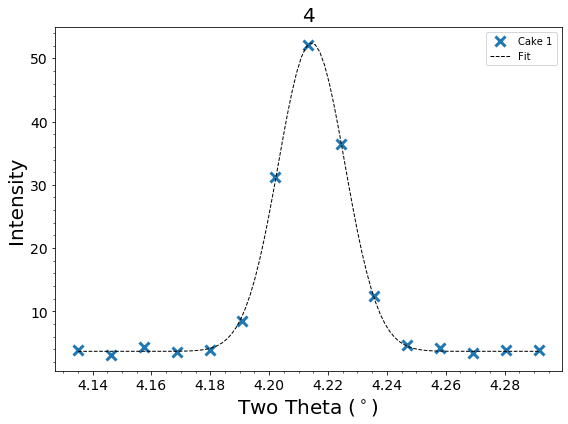

In [25]:
peak_params = [PeakParams('1', (2.75, 2.95)),
               PeakParams('Triplet',  (3.02, 3.32), [(3.09, 3.12), (3.19, 3.22), (3.24, 3.26)]),
               PeakParams('4', (4.13, 4.30))]

spectral_data.fit_peaks(peak_params, 1)

for fit in spectral_data.fitted_peaks:
    fit.plot()